In [ ]:
import tensorflow as tf
keras = tf.keras
import warnings
warnings.filterwarnings("ignore")
import gensim, re
import numpy as np
import pandas as pd
import openpyxl
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.models import load_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Bidirectional, Dropout
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
!pip install bltk
!pip install pandas
import pandas as pd
from bltk.langtools import remove_stopwords
import regex as re
from bltk.langtools import Tokenizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#df=pd.read_excel('/content/drive/MyDrive/suicide/suicide_data2.xlsx')
#main_data = pd.read_excel( "/content/drive/MyDrive/suicide/suicide_data2.xlsx" )
df=pd.read_excel('/content/drive/MyDrive/suicide/suicide_data.xlsx')
main_data = pd.read_excel( "/content/drive/MyDrive/suicide/suicide_data.xlsx" )
labels = main_data['label'].tolist()
df.head()

,text,label
0,আমি একদিন নিজেকে মেরে ফেলব এই বিষয়টি আমি নিশ...,1
1,বেচে থাকার কোন কারণ আমি ভাবতে পারি না। জীবনের ...,1
2,আমি কমপক্ষে ১ বছর ধরে সুইসাইড করার কথা ভাবছি। ...,1
3,আমার আর বাঁচার দরকার নেই। আমি ওর সাথে সম্পর্ক...,1
4,আমি এভাবে আর বাঁচব না। আমার হতাশা ও আত্মহত্যার...,1


In [ ]:
from bltk.langtools.banglachars import (vowels,
                                        vowel_signs,
                                        consonants,
                                        digits,
                                        operators,
                                        punctuations,
                                        others)
print(f'Vowels: {vowels}')
print(f'Vowel signs: {vowel_signs}')
print(f'Consonants: {consonants}')
print(f'Digits: {digits}')
print(f'Operators: {operators}')
print(f'Punctuation marks: {punctuations}')
print(f'Others: {others}')

Vowels: ['অ', 'আ', 'ই', 'ঈ', 'উ', 'ঊ', 'ঋ', 'ঌ', 'এ', 'ঐ', 'ও', 'ঔ']
Vowel signs: ['া', 'ি', 'ী', 'ু', 'ূ', 'ৃ', 'ৄ', 'ে', 'ৈ', 'ো', 'ৌ']
Consonants: ['ক', 'খ', 'গ', 'ঘ', 'ঙ', 'চ', 'ছ', 'জ', 'ঝ', 'ঞ', 'ট', 'ঠ', 'ড', 'ঢ', 'ণ', 'ত', 'থ', 'দ', 'ধ', 'ন', 'প', 'ফ', 'ব', 'ভ', 'ম', 'য', 'র', 'ল', 'শ', 'ষ', 'স', 'হ', 'ড়', 'ঢ়', 'য়', 'ৎ', 'ং', 'ঃ', 'ঁ']
Digits: ['০', '১', '২', '৩', '৪', '৫', '৬', '৭', '৮', '৯']
Operators: ['=', '+', '-', '*', '/', '%', '<', '>', '×', '÷']
Punctuation marks: ['।', ',', ';', ':', '?', '!', "'", '.', '"', '-', '[', ']', '{', '}', '(', ')', '–', '—', '―', '~']
Others: ['৳', '৺', '্', 'ঀ', 'ঽ', '#', '$']


In [ ]:
def punc(tokens):
  valid_tokens=[]
  for token in tokens:
    if token not in punctuations:
      valid_tokens.append(token)
  tokens=valid_tokens
  return tokens

In [ ]:
new_list=[]
for c in vowels:
  new_list.append(c)
for c in vowel_signs:
  new_list.append(c)
for c in consonants:
  new_list.append(c)
new_list.append('্')
new_list.append('য়')
def tokenize(text):
    token=[]
    text=str(text)
    #print(text)
    new_text=""
    for c in text:
      if c in new_list:
        new_text=new_text+c
      else:
        new_text=new_text+' '
    tokenizer = Tokenizer()
    text=new_text
    words=tokenizer.word_tokenizer(text)
    for word in words:
      if word not in token:
        siz=0
        for c in word:
          siz=siz+1
        if siz>0:
          token.append(word)
    return token

In [ ]:
def stp_remove(tkn):
  words=remove_stopwords(tkn, level='soft')
  return words

In [ ]:
df2=pd.read_excel('/content/drive/MyDrive/suicide/rules.xlsx')
pd.set_option('display.max_rows', None)
df2.head()
#print(df2)

,rule
0,ই
1,ও
2,তো
3,কে
4,তে


In [ ]:
def stemming(text, pattern):
    mi=min(len(text),len(pattern))
    cnt=0
    len_text=len(text)
    len_pattern=len(pattern)
    cnt=-2
    for i in range(mi):
      if(text[len_text-(i+1)]!=pattern[len_pattern-(i+1)]):
        break
      cnt=i
    len_text=len_text-cnt
    txt=text
    if cnt+1==mi:
      txt = text[0:len_text-1]
    return txt

In [ ]:
posts= list()
for text in df["text"]:
    text=str(text)
    text=tokenize(text)
    text=punc(text)
    text=stp_remove(text)
    new_tokens=[]
    for txt in text:
       temp=txt
       for rule in df2["rule"]:
           temp=stemming(txt,rule)
           if temp!=txt:
               break
       if len(temp)>0:
          new_tokens.append(temp)
    posts.append(new_tokens)
cleaned_data=posts

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
features = 100
tokenizer = Tokenizer(num_words=features)

In [ ]:

tokenizer.fit_on_texts(cleaned_data)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(cleaned_data)

maxlen=10
padType='post'

X = pad_sequences(sequences, maxlen=maxlen, padding="post", truncating="post")
y = np.asarray(pd.get_dummies(labels))

In [ ]:
len(X), len(y)

(4005, 4005)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True)

In [ ]:


def get_model(num_of_layer):
    model = Sequential()
    model.add(Embedding(4000, features, input_length = X.shape[1]))
    
    for i in range(num_of_layer):
        if i>0:
            model.add(LSTM(features, return_sequences=True))
        
    model.add(LSTM(features, return_sequences=False))
    model.add(Dense(10, activation="relu"))
    model.add(Dense(y.shape[1], activation="softmax"))

    opt = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model;

In [ ]:
def run_model(model, batch, epochs):
    history = model.fit(X_train, y_train, batch, epochs, validation_data=(X_test, y_test), verbose=1)
    return history

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()


Epoch 1/10
101/101 [==============================] - 4s 17ms/step - loss: 0.6902 - accuracy: 0.5346 - val_loss: 0.6836 - val_accuracy: 0.5668
Epoch 2/10
101/101 [==============================] - 1s 13ms/step - loss: 0.6619 - accuracy: 0.6536 - val_loss: 0.5972 - val_accuracy: 0.7503
Epoch 3/10
101/101 [==============================] - 1s 13ms/step - loss: 0.5114 - accuracy: 0.7790 - val_loss: 0.4293 - val_accuracy: 0.8090
Epoch 4/10
101/101 [==============================] - 2s 18ms/step - loss: 0.4423 - accuracy: 0.7978 - val_loss: 0.4059 - val_accuracy: 0.8190
Epoch 5/10
101/101 [==============================] - 2s 17ms/step - loss: 0.4282 - accuracy: 0.8046 - val_loss: 0.3997 - val_accuracy: 0.8227
Epoch 6/10
101/101 [==============================] - 1s 13ms/step - loss: 0.4224 - accuracy: 0.8031 - val_loss: 0.3988 - val_accuracy: 0.8165
Epoch 7/10
101/101 [==============================] - 1s 14ms/step - loss: 0.4176 - accuracy: 0.8084 - val_loss: 0.3991 - val_accuracy: 0.8102

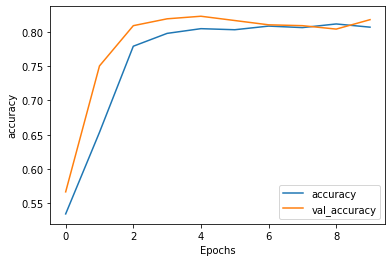

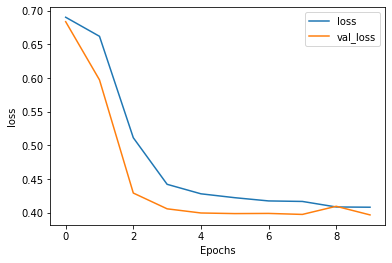

26/26 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       412
           1       0.85      0.75      0.80       389

    accuracy                           0.82       801
   macro avg       0.82      0.82      0.82       801
weighted avg       0.82      0.82      0.82       801

Epoch 1/10
101/101 [==============================] - 10s 41ms/step - loss: 0.6914 - accuracy: 0.5808 - val_loss: 0.6796 - val_accuracy: 0.6242
Epoch 2/10
101/101 [==============================] - 3s 31ms/step - loss: 0.6028 - accuracy: 0.7125 - val_loss: 0.4469 - val_accuracy: 0.8027
Epoch 3/10
101/101 [==============================] - 4s 38ms/step - loss: 0.4658 - accuracy: 0.7871 - val_loss: 0.4146 - val_accuracy: 0.8140
Epoch 4/10
101/101 [==============================] - 3s 30ms/step - loss: 0.4429 - accuracy: 0.7999 - val_loss: 0.4115 - val_accuracy: 0.8127
Epoch 5/10
101/101 [===========================

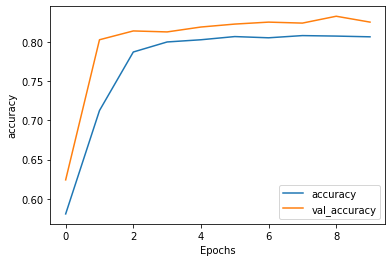

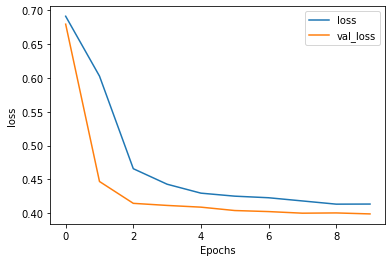

26/26 [==============================] - 1s 9ms/step
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       412
           1       0.85      0.78      0.81       389

    accuracy                           0.83       801
   macro avg       0.83      0.82      0.82       801
weighted avg       0.83      0.83      0.82       801

Epoch 1/10
101/101 [==============================] - 14s 67ms/step - loss: 0.6890 - accuracy: 0.5259 - val_loss: 0.6611 - val_accuracy: 0.6142
Epoch 2/10
101/101 [==============================] - 4s 42ms/step - loss: 0.5908 - accuracy: 0.7138 - val_loss: 0.4568 - val_accuracy: 0.7953
Epoch 3/10
101/101 [==============================] - 5s 46ms/step - loss: 0.4654 - accuracy: 0.7843 - val_loss: 0.4368 - val_accuracy: 0.8027
Epoch 4/10
101/101 [==============================] - 5s 46ms/step - loss: 0.4479 - accuracy: 0.7931 - val_loss: 0.4132 - val_accuracy: 0.8140
Epoch 5/10
101/101 [===========================

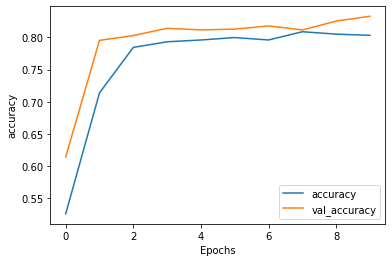

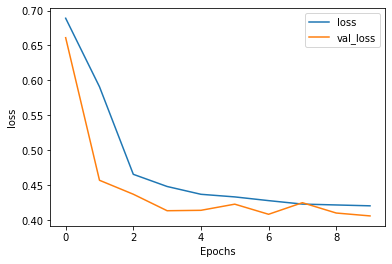

26/26 [==============================] - 2s 11ms/step
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       412
           1       0.84      0.80      0.82       389

    accuracy                           0.83       801
   macro avg       0.83      0.83      0.83       801
weighted avg       0.83      0.83      0.83       801

Epoch 1/20
101/101 [==============================] - 3s 17ms/step - loss: 0.6903 - accuracy: 0.5446 - val_loss: 0.6864 - val_accuracy: 0.5518
Epoch 2/20
101/101 [==============================] - 2s 20ms/step - loss: 0.6730 - accuracy: 0.6136 - val_loss: 0.6196 - val_accuracy: 0.7453
Epoch 3/20
101/101 [==============================] - 2s 16ms/step - loss: 0.5252 - accuracy: 0.7662 - val_loss: 0.4297 - val_accuracy: 0.8102
Epoch 4/20
101/101 [==============================] - 1s 13ms/step - loss: 0.4562 - accuracy: 0.7946 - val_loss: 0.4204 - val_accuracy: 0.8127
Epoch 5/20
101/101 [===========================

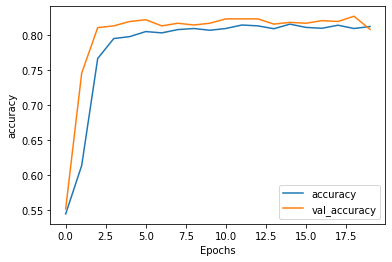

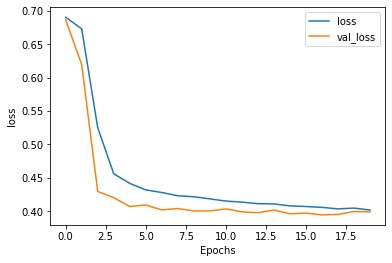

26/26 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.77      0.90      0.83       412
           1       0.87      0.71      0.78       389

    accuracy                           0.81       801
   macro avg       0.82      0.81      0.81       801
weighted avg       0.82      0.81      0.81       801

Epoch 1/20
101/101 [==============================] - 11s 48ms/step - loss: 0.6852 - accuracy: 0.6149 - val_loss: 0.6514 - val_accuracy: 0.7066
Epoch 2/20
101/101 [==============================] - 4s 41ms/step - loss: 0.5369 - accuracy: 0.7575 - val_loss: 0.4374 - val_accuracy: 0.8052
Epoch 3/20
101/101 [==============================] - 3s 32ms/step - loss: 0.4537 - accuracy: 0.7984 - val_loss: 0.4157 - val_accuracy: 0.8127
Epoch 4/20
101/101 [==============================] - 3s 31ms/step - loss: 0.4401 - accuracy: 0.7993 - val_loss: 0.4101 - val_accuracy: 0.8177
Epoch 5/20
101/101 [===========================

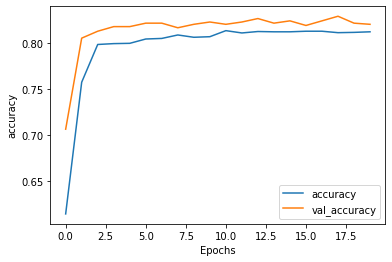

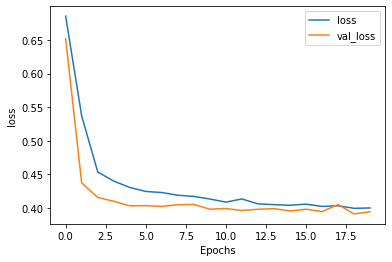

26/26 [==============================] - 1s 8ms/step
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       412
           1       0.86      0.75      0.80       389

    accuracy                           0.82       801
   macro avg       0.83      0.82      0.82       801
weighted avg       0.82      0.82      0.82       801

Epoch 1/20
101/101 [==============================] - 14s 70ms/step - loss: 0.6875 - accuracy: 0.5321 - val_loss: 0.6533 - val_accuracy: 0.6704
Epoch 2/20
101/101 [==============================] - 5s 46ms/step - loss: 0.5580 - accuracy: 0.7463 - val_loss: 0.4310 - val_accuracy: 0.8152
Epoch 3/20
101/101 [==============================] - 6s 55ms/step - loss: 0.4540 - accuracy: 0.7868 - val_loss: 0.4178 - val_accuracy: 0.8115
Epoch 4/20
101/101 [==============================] - 5s 45ms/step - loss: 0.4394 - accuracy: 0.7934 - val_loss: 0.4068 - val_accuracy: 0.8215
Epoch 5/20
101/101 [===========================

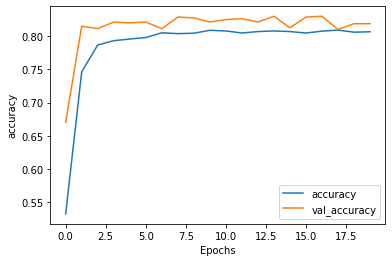

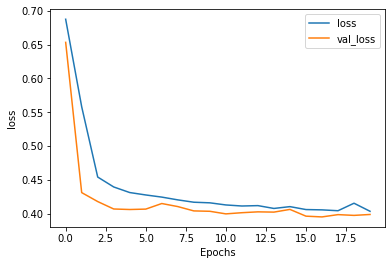

26/26 [==============================] - 2s 13ms/step
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       412
           1       0.85      0.77      0.80       389

    accuracy                           0.82       801
   macro avg       0.82      0.82      0.82       801
weighted avg       0.82      0.82      0.82       801

Epoch 1/30
101/101 [==============================] - 4s 18ms/step - loss: 0.6915 - accuracy: 0.5275 - val_loss: 0.6895 - val_accuracy: 0.5293
Epoch 2/30
101/101 [==============================] - 1s 14ms/step - loss: 0.6848 - accuracy: 0.5574 - val_loss: 0.6683 - val_accuracy: 0.5730
Epoch 3/30
101/101 [==============================] - 2s 20ms/step - loss: 0.6075 - accuracy: 0.7007 - val_loss: 0.4562 - val_accuracy: 0.7990
Epoch 4/30
101/101 [==============================] - 2s 16ms/step - loss: 0.4650 - accuracy: 0.7918 - val_loss: 0.4131 - val_accuracy: 0.8102
Epoch 5/30
101/101 [===========================

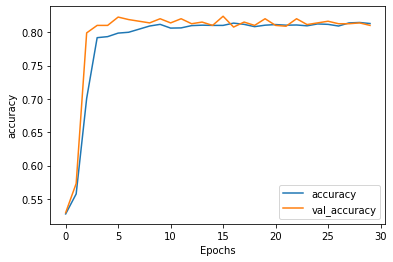

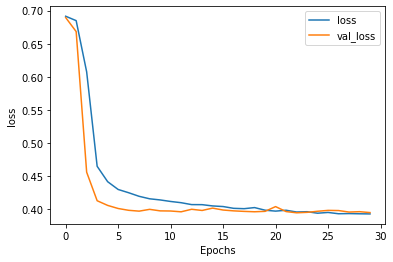

26/26 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.78      0.87      0.83       412
           1       0.85      0.74      0.79       389

    accuracy                           0.81       801
   macro avg       0.82      0.81      0.81       801
weighted avg       0.81      0.81      0.81       801

Epoch 1/30
101/101 [==============================] - 10s 50ms/step - loss: 0.6811 - accuracy: 0.5568 - val_loss: 0.6507 - val_accuracy: 0.6367
Epoch 2/30
101/101 [==============================] - 3s 33ms/step - loss: 0.5948 - accuracy: 0.7400 - val_loss: 0.4794 - val_accuracy: 0.8127
Epoch 3/30
101/101 [==============================] - 3s 33ms/step - loss: 0.4551 - accuracy: 0.7806 - val_loss: 0.4178 - val_accuracy: 0.8002
Epoch 4/30
101/101 [==============================] - 4s 37ms/step - loss: 0.4349 - accuracy: 0.7934 - val_loss: 0.4069 - val_accuracy: 0.8215
Epoch 5/30
101/101 [===========================

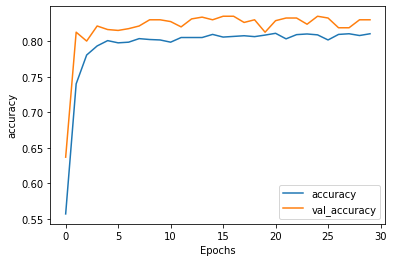

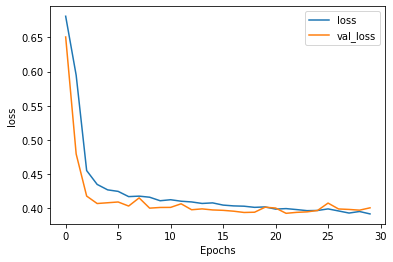

26/26 [==============================] - 1s 10ms/step
              precision    recall  f1-score   support

           0       0.83      0.84      0.84       412
           1       0.83      0.82      0.82       389

    accuracy                           0.83       801
   macro avg       0.83      0.83      0.83       801
weighted avg       0.83      0.83      0.83       801

Epoch 1/30
101/101 [==============================] - 15s 70ms/step - loss: 0.6886 - accuracy: 0.5234 - val_loss: 0.6576 - val_accuracy: 0.6717
Epoch 2/30
101/101 [==============================] - 5s 47ms/step - loss: 0.5432 - accuracy: 0.7484 - val_loss: 0.4248 - val_accuracy: 0.8165
Epoch 3/30
101/101 [==============================] - 5s 54ms/step - loss: 0.4560 - accuracy: 0.7865 - val_loss: 0.4247 - val_accuracy: 0.8177
Epoch 4/30
101/101 [==============================] - 5s 46ms/step - loss: 0.4464 - accuracy: 0.7912 - val_loss: 0.4080 - val_accuracy: 0.8165
Epoch 5/30
101/101 [==========================

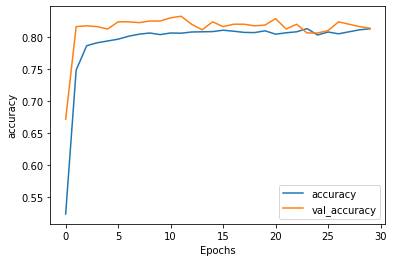

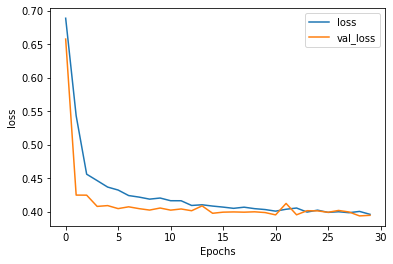

26/26 [==============================] - 3s 14ms/step
              precision    recall  f1-score   support

           0       0.78      0.88      0.83       412
           1       0.86      0.74      0.80       389

    accuracy                           0.81       801
   macro avg       0.82      0.81      0.81       801
weighted avg       0.82      0.81      0.81       801



In [ ]:
arr_batch = [32]
arr_epochs = [10,20,30]
algo_layers = [1,3,5]
output = {}
idx = 0
for batch in arr_batch:
    for epoch in arr_epochs:
        for layer in algo_layers:
            model = get_model(layer)
            history = run_model(model, batch, epoch)
            ev = model.evaluate(X_test, y_test)
            
            plot_graphs(history, "accuracy")
            plot_graphs(history, "loss")

            y_pred=model.predict(X_test) 
            y_pred=np.argmax(y_pred, axis=1)
            formated_y_test=np.argmax(y_test, axis=1)
            cm = classification_report(formated_y_test, y_pred)
            print(cm)
            
            output[idx] = {'batch':batch, 'epoch':epoch, 'num_of_layer':layer, 'acc':ev, 'cm':cm}
            idx = idx+1;

In [ ]:
output

{0: {'batch': 32,
  'epoch': 10,
  'num_of_layer': 1,
  'acc': [0.3968700170516968, 0.8177278637886047],
  'cm': '              precision    recall  f1-score   support\n\n           0       0.79      0.88      0.83       412\n           1       0.85      0.75      0.80       389\n\n    accuracy                           0.82       801\n   macro avg       0.82      0.82      0.82       801\nweighted avg       0.82      0.82      0.82       801\n'},
 1: {'batch': 32,
  'epoch': 10,
  'num_of_layer': 3,
  'acc': [0.3989642858505249, 0.8252184987068176],
  'cm': '              precision    recall  f1-score   support\n\n           0       0.81      0.87      0.84       412\n           1       0.85      0.78      0.81       389\n\n    accuracy                           0.83       801\n   macro avg       0.83      0.82      0.82       801\nweighted avg       0.83      0.83      0.82       801\n'},
 2: {'batch': 32,
  'epoch': 10,
  'num_of_layer': 5,
  'acc': [0.40576720237731934, 0.832709133

In [ ]:
import json
json_object = json.dumps(output, indent = 4)
with open('lstm_dense.json', 'a') as fp:
    fp.write(json_object)